In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from types import MethodType
from torchvision.models.resnet import Bottleneck
from sklearn.decomposition import PCA
import os, time, copy, math, random
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
import umap
from tqdm import tqdm

/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Baseline Setup

Loading Pretrained ResNet

In [3]:
pretrained_resnet = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)

Downloading CIFAR-10

In [4]:
# Define transform to convert images to tensor and normalize
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Download CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, download=True, transform=transform)

In [5]:
trainloader = DataLoader(trainset, batch_size=48, shuffle=True)
testloader = DataLoader(testset, batch_size=48, shuffle=False)

In [6]:
# CLASSES
print(len(trainset.classes))
print(trainset.classes)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Modfying Resnet

In [7]:
# REPLACING FINAL LAYER
pretrained_resnet.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True) 
# FREEZING BACKBONE
for param in pretrained_resnet.parameters():
    param.requires_grad = False
for param in pretrained_resnet.fc.parameters():
    param.requires_grad = True

Training New Classification Head

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
pretrained_resnet = pretrained_resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.fc.parameters(), lr=0.005)

cuda


In [50]:
num_epochs = 5
for epoch in (range(num_epochs)):
    pretrained_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    pretrained_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"\tValidation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.6466, Train Acc: 78.92%
	Validation Acc: 81.38%
Epoch 2
	Training Loss: 0.5490, Train Acc: 82.60%
	Validation Acc: 83.43%
Epoch 3
	Training Loss: 0.5231, Train Acc: 83.54%
	Validation Acc: 82.71%
Epoch 4
	Training Loss: 0.5232, Train Acc: 83.74%
	Validation Acc: 82.83%
Epoch 5
	Training Loss: 0.5245, Train Acc: 83.67%
	Validation Acc: 82.68%


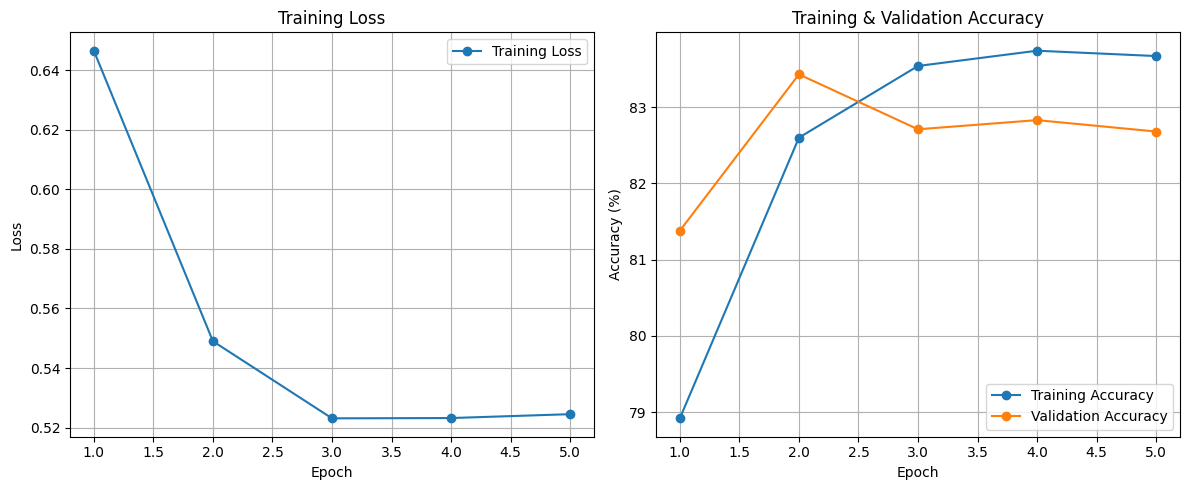

In [51]:
training_losses = [0.6466,0.5490,0.5231,0.5232,0.5245]
training_accuracies = [78.92,82.60,83.54,83.74,83.67]
validation_accuracies = [81.38,83.43,82.71,82.83,82.68]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].grid(True)
axs[0].legend()

# Plot accuracies
axs[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training & Validation Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

### Residual Connections in Practice

In [52]:
def make_forward():
    def forward(self: Bottleneck, x):
        out = self.conv1(x) 
        out = self.bn1(out) 
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        out = out
        out = self.relu(out)
        return out
    return forward

targets = [
    ("layer2", 3),   
    ("layer3", 5),
    ("layer4", 0),
]

for layer_name, idx in targets:
    blk = getattr(pretrained_resnet, layer_name)[idx]
    blk.forward = MethodType(make_forward(), blk)

In [53]:
num_epochs = 3
for epoch in range(num_epochs):
    pretrained_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    pretrained_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

Epoch 1, Loss: 2.3871, Train Acc: 10.66%
Validation Acc: 10.16%
Epoch 2, Loss: 2.3517, Train Acc: 11.18%
Validation Acc: 10.58%
Epoch 3, Loss: 2.3400, Train Acc: 11.46%
Validation Acc: 11.70%


In [ ]:
training_losses = [2.3871,2.3517,2.3400]
training_accuracies = [10.66,11.18,11.46]
validation_accuracies = [10.16,10.58,11.70]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].grid(True)
axs[0].legend()

# Plot accuracies
axs[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training & Validation Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

### Feature Hierarchies and Representations

In [6]:
len(testloader)

209

In [7]:
import torch
from torchvision import models
from sklearn.decomposition import IncrementalPCA
import umap
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pretrained_resnet.to(device).eval()  # your model

tap_points = {
    "early":  model.layer1[-1],
    "middle": model.layer3[-1],
    "late":   model.layer4[-1],
}

# ---- Pass 1: fit IncrementalPCA on batches (no storing of big features) ----
N_COMP = min(100, testloader.batch_size)   # e.g., 48
ipca = {k: IncrementalPCA(n_components=N_COMP, batch_size=256) for k in tap_points}


def make_fit_hook(name):
    def hook(_m, _inp, out):
        X = out.flatten(1).detach().cpu().numpy() if out.dim()==4 else out.detach().cpu().numpy()
        ipca[name].partial_fit(X)
    return hook

handles = [tap_points[k].register_forward_hook(make_fit_hook(k)) for k in tap_points]
import itertools

with torch.inference_mode():
    for x, _ in itertools.islice(testloader, 3):  # first 3 batches only
        _ = model(x.to(device, non_blocking=True))
for h in handles: h.remove()

# ---- Pass 2: transform to 100D on the fly, store only small matrices -------
buffers_small = {k: [] for k in tap_points}

def make_transform_hook(name):
    def hook(_m, _inp, out):
        X = out.flatten(1).detach().cpu().numpy() if out.dim()==4 else out.detach().cpu().numpy()
        Z = ipca[name].transform(X)          # [B, 100]
        buffers_small[name].append(Z)
    return hook

handles = [tap_points[k].register_forward_hook(make_transform_hook(k)) for k in tap_points]
labels = []
with torch.inference_mode():
    for x, y in testloader:
        _ = model(x.to(device, non_blocking=True))
        labels.append(y)
for h in handles: h.remove()

labels = torch.cat(labels).numpy()
feats100 = {k: np.concatenate(v, axis=0) for k, v in buffers_small.items()}  # [N, 100] each

# ---- UMAP on 100D (much smaller) ------------------------------------------
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=0)
embeddings = {k: reducer.fit_transform(v) for k, v in feats100.items()}  # [N, 2] each


/home/csalt/anaconda3/envs/illm/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


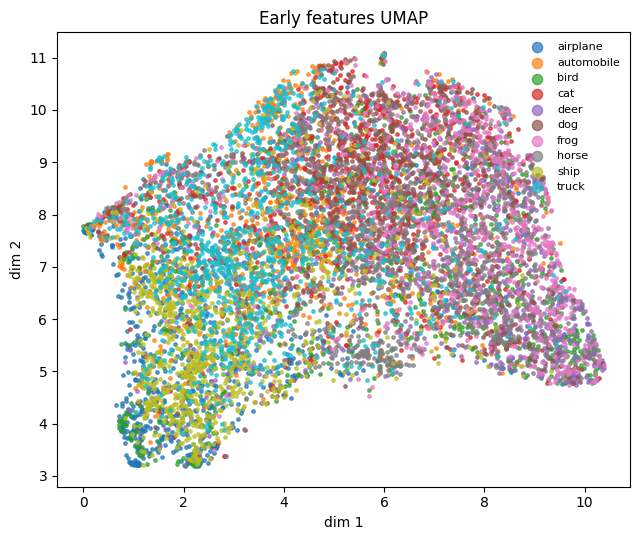

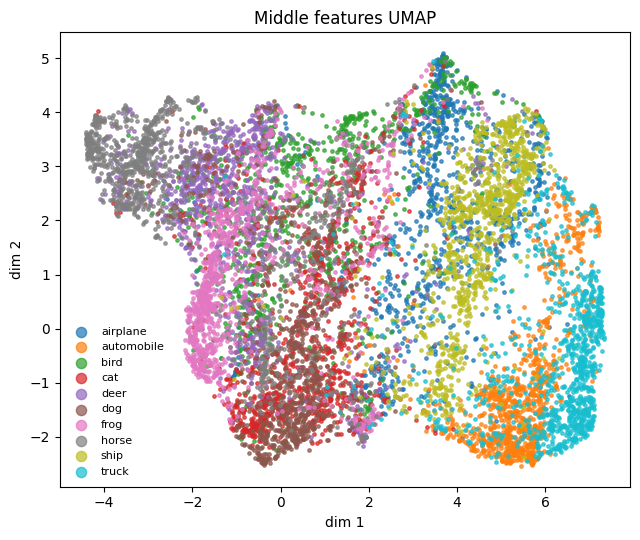

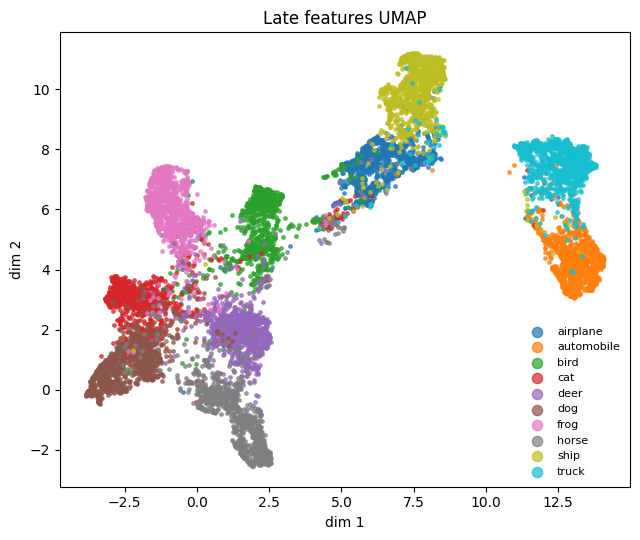

In [8]:
def plot_scatter(Z, y, title):
    plt.figure(figsize=(6.5, 5.5))
    # Let matplotlib choose colors; 10 classes -> 10 colors
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.7, label=trainset.classes[c])
    plt.legend(markerscale=3, fontsize=8, loc='best', frameon=False)
    plt.title(title)
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.tight_layout()
    plt.show()

for name, Z in embeddings.items():
    plot_scatter(Z, labels, f"{name.capitalize()} features UMAP")

### Transfer Learning and Generalisation

Train from random initialization

In [9]:
random_resnet = torchvision.models.resnet152(weights=None)
random_resnet.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True) 

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
random_resnet = random_resnet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(random_resnet.parameters(), lr=0.001)

num_epochs = 5
for epoch in (range(num_epochs)):
    random_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = random_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    random_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = random_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"\tValidation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 1.6845, Train Acc: 37.22%
	Validation Acc: 50.48%
Epoch 2
	Training Loss: 1.1528, Train Acc: 58.14%
	Validation Acc: 63.60%
Epoch 3
	Training Loss: 0.8659, Train Acc: 69.12%
	Validation Acc: 72.12%
Epoch 4
	Training Loss: 0.7048, Train Acc: 75.45%
	Validation Acc: 75.97%
Epoch 5
	Training Loss: 0.5802, Train Acc: 79.89%
	Validation Acc: 77.88%


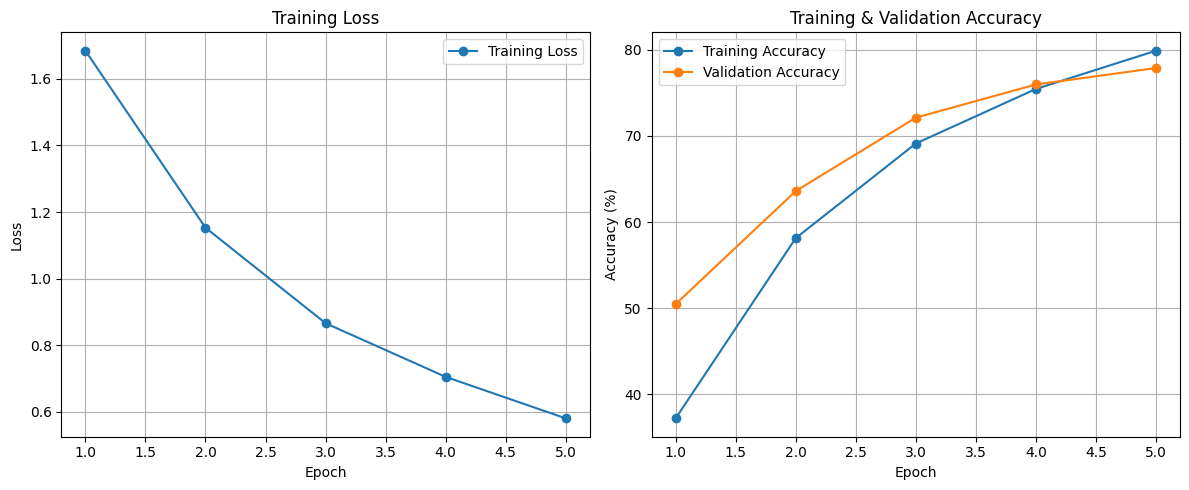

In [11]:
training_losses = [1.6845, 1.1528, 0.8659, 0.7048, 0.5802]
training_accuracies = [37.22, 58.14, 69.12, 75.45, 79.89]
validation_accuracies = [50.48, 63.60, 72.12, 75.97, 77.88]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].grid(True)
axs[0].legend()

# Plot accuracies
axs[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training & Validation Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

Full fine-tuning

In [10]:
full_resnet = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
full_resnet.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_resnet = full_resnet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(full_resnet.parameters(), lr=0.001)

num_epochs = 5
for epoch in (range(num_epochs)):
    full_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = full_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    full_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = full_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"\tValidation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.5380, Train Acc: 81.86%
	Validation Acc: 87.12%
Epoch 2
	Training Loss: 0.2918, Train Acc: 90.08%
	Validation Acc: 88.51%
Epoch 3
	Training Loss: 0.2104, Train Acc: 92.77%
	Validation Acc: 90.90%
Epoch 4
	Training Loss: 0.1566, Train Acc: 94.57%
	Validation Acc: 91.26%
Epoch 5
	Training Loss: 0.1204, Train Acc: 95.82%
	Validation Acc: 91.64%


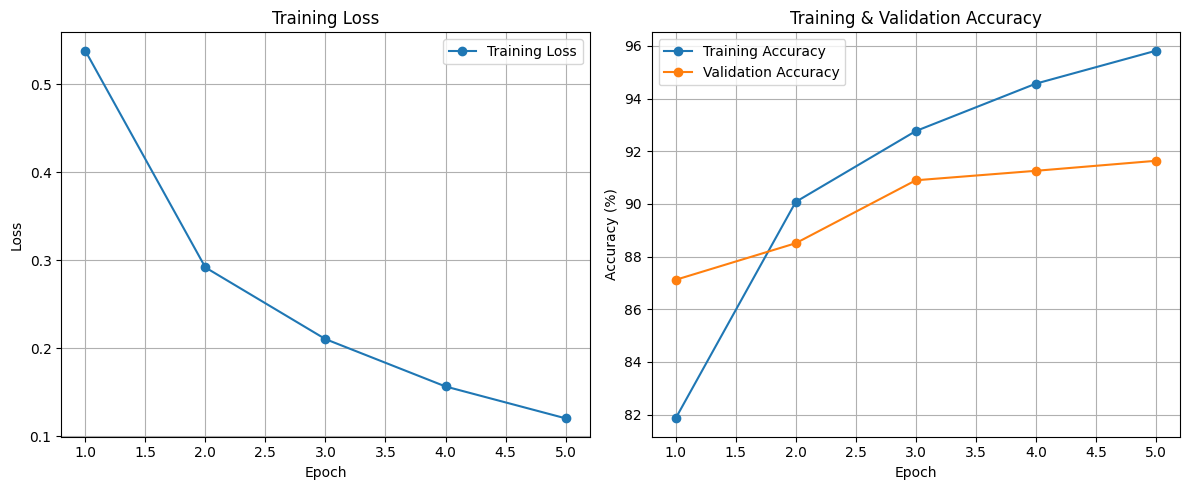

In [12]:
training_losses = [0.5380, 0.2918, 0.2104, 0.1566, 0.1204]
training_accuracies = [81.86, 90.08, 92.77, 94.57, 95.82]
validation_accuracies = [87.12, 88.51, 90.90, 91.26, 91.64]
                         
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].grid(True)
axs[0].legend()

# Plot accuracies
axs[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training & Validation Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()